In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

if os.getcwd()[-7:] == 'AAM_Sim':
    print(os.getcwd())
else:
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    print(os.getcwd())
    
from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate
from Engine.DragModel import DragModel
from Engine.TrackingSystem import *
from Engine.ConflictDetector import ConflictDetector

from CrossPlatformDev import my_print, join_str

import time

C:\Users\quekz\PycharmProjects\AAM_Sim


In [2]:
def FP_gen(HDG, speed, time, num_wpts, ini_pos):
    """Function that generates a flight plan according to encounter design. 
    A/C have fixed heading and will fly toward WPTs. 
    HDG --> desired A/C HDG (counter-clockwise from x-axis in RADIANS)
    speed --> desired A/C cruise spd
    time --> approximate duration for each flight leg (between 2 consecutive wpts)
    num_wpts --> number of wpts along the flight path
    ini_pos --> initial position of the A/C
    """
    wpt_list = []
    wpt_times = []
    spds = []
    mode_list = []
    duration_list = []
    for i in range(num_wpts):
        wpt_list.append(ini_pos + i*speed*time*np.array([np.cos(HDG), np.sin(HDG), 0]))
        wpt_times.append(i*time*1.1) # Give a 10% margin to each leg duration
        if i > 0:
            spds.append(speed)
            mode_list.append('Direct_P2P')
            duration_list.append(time*1.1) # Give a 10% margin to each leg duration
    wpt_start_list = wpt_list[0:num_wpts-1]
    wpt_end_list = wpt_list[1:]
    wpt_start_time = wpt_times[0:num_wpts-1]
    wpt_end_time = wpt_times[1:]
    return (FlightPlan(spds, mode_list,
                       wpt_start_list, wpt_start_time,
                       wpt_end_list, wpt_end_time, duration_list), wpt_list)


def calc_diameter(mass):
    """Data for this function obtained from log-log plot of popular DJI quadrotors"""
    if isinstance(mass, type(np.array([]))):
        diameter = (np.random.uniform(0.8, 1.2, size=len(mass)) * np.exp((0.3878 * np.log(mass) + 2.1387))).round(1)
    else:
        diameter = round(np.random.uniform(0.8, 1.2) * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    return diameter

In [3]:
# File to be used for generating initial params

# Number of runs
num_runs = 100000

# Global Params

GlobalPhysicsUpdateRate = 240 * np.ones(num_runs)
GlobalSimStopTime = 200 * np.ones(num_runs)
Cruise_Leg_Time = 15 * np.ones(num_runs)
Num_Legs = 5 * np.ones(num_runs)

WindUpdateRate = 1 * np.ones(num_runs)
Wind_auto_x = 0.9 * np.ones(num_runs)
Wind_auto_y = 0.9 * np.ones(num_runs)
Wind_auto_z = 0 * np.ones(num_runs)
Wind_std_x = 3 * np.ones(num_runs)
Wind_std_y = 3 * np.ones(num_runs)
Wind_std_z = 0 * np.ones(num_runs)
Wind_mean_x = 0 * np.ones(num_runs)
Wind_mean_y = 0 * np.ones(num_runs)
Wind_mean_z = 0 * np.ones(num_runs)

# Some shared AC Params for this simulation

# AC GPS Error Models
GPS_Pos_Error_Hor_Auto = 0.994
GPS_Pos_Error_Vert_Auto = 0.994
GPS_Pos_Error_Hor_Std = 4.0854 # (radial)
# GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std)/np.sqrt(0.5*(4-np.pi)) # Check formula! 
# GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running!
GPS_Pos_Error_Vert_Std = 1.5306

# AC Cruise Spds
upper_spd = 20
lower_spd = 5

# Tracking Unit Clk Sync Err --- NEW!!!
clk_sync_std = 5.1021 * (10**(-3))  # Make sure it's in seconds!


# AC1 Params
AC1_Mass = np.random.uniform(0.25, 25, size=num_runs)
AC1_Prop_Diameter = calc_diameter(AC1_Mass)
AC1_HDG = np.random.uniform(0, 360, size=num_runs)
# AC1_HDG = np.ones(num_runs) * 0
AC1_HDG = AC1_HDG * np.pi/180
AC1_Cruise_Speed = np.random.uniform(lower_spd,upper_spd, size=(num_runs))
radii = np.random.uniform(20,50, size=(num_runs)) * AC1_Cruise_Speed
# radii = np.random.uniform(39.9,40, size=(num_runs)) * AC1_Cruise_Speed
AC1_Ini_Pos_x = -radii * np.cos(AC1_HDG)
AC1_Ini_Pos_y = -radii * np.sin(AC1_HDG)
AC1_Ini_Pos_z =  np.zeros(num_runs)

AC1_Ini_Vel_x = np.zeros(num_runs)
AC1_Ini_Vel_y = np.zeros(num_runs)
AC1_Ini_Vel_z = np.zeros(num_runs)

AC1_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC1_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC1_GPS_horizontal_auto = AC1_GPS_horizontal_auto * np.ones(num_runs)

AC1_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC1_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC1_GPS_vert_auto = AC1_GPS_vert_auto * np.ones(num_runs)

AC1_Ini_Pos_Err_x = np.random.normal(0, AC1_GPS_horizontal_std, size=num_runs)
AC1_Ini_Pos_Err_y = np.random.normal(0, AC1_GPS_horizontal_std, size=num_runs)
AC1_Ini_Pos_Err_z =  np.random.normal(0, AC1_GPS_vert_std, size=num_runs)

AC1_GPS_horizontal_std = AC1_GPS_horizontal_std * np.ones(num_runs)
AC1_GPS_vert_std = AC1_GPS_vert_std * np.ones(num_runs)

AC1_Ini_Vel_Err_x = np.zeros(num_runs) 
AC1_Ini_Vel_Err_y = np.zeros(num_runs)
AC1_Ini_Vel_Err_z = np.zeros(num_runs)

AC1_Ini_RPY_r = np.zeros(num_runs)
AC1_Ini_RPY_p = np.zeros(num_runs)
AC1_Ini_RPY_y = np.zeros(num_runs)

AC1_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC1_Controller_UpdateRate = 120 * np.ones(num_runs)
AC1_Start_Time = 0 * np.ones(num_runs)

AC1_PosUpdateRate = 10 * np.ones(num_runs)
AC1_VelUpdateRate = 10 * np.ones(num_runs)
AC1_AccelUpdateRate = 120 * np.ones(num_runs)
AC1_AirSpdSensorUpdateRate = 120 * np.ones(num_runs)

AC1_Trk_Unit_Clk_Sync_Err = np.random.normal(0, clk_sync_std, size=num_runs)


# AC2 Params
AC2_Mass = np.random.uniform(0.25, 25, size=num_runs)
AC2_Prop_Diameter = calc_diameter(AC2_Mass)
AC2_HDG = np.random.uniform(0, 360, size=num_runs)
# AC2_HDG = np.ones(num_runs) * 90
AC2_HDG = AC2_HDG * np.pi/180
AC2_Cruise_Speed = np.random.uniform(lower_spd,upper_spd, size=(num_runs))
radii = np.random.uniform(20,50, size=(num_runs)) * AC2_Cruise_Speed
# radii = np.random.uniform(39.9,40, size=(num_runs)) * AC2_Cruise_Speed
AC2_Ini_Pos_x = -radii * np.cos(AC2_HDG)
AC2_Ini_Pos_y = -radii * np.sin(AC2_HDG)
AC2_Ini_Pos_z =  np.zeros(num_runs)

AC2_Ini_Vel_x = np.zeros(num_runs)
AC2_Ini_Vel_y = np.zeros(num_runs)
AC2_Ini_Vel_z = np.zeros(num_runs)

AC2_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC2_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC2_GPS_horizontal_auto = AC2_GPS_horizontal_auto * np.ones(num_runs)

AC2_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC2_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC2_GPS_vert_auto = AC2_GPS_vert_auto * np.ones(num_runs)

AC2_Ini_Pos_Err_x = np.random.normal(0, AC2_GPS_horizontal_std, size=num_runs)
AC2_Ini_Pos_Err_y = np.random.normal(0, AC2_GPS_horizontal_std, size=num_runs)
AC2_Ini_Pos_Err_z =  np.random.normal(0, AC2_GPS_vert_std, size=num_runs)

AC2_GPS_horizontal_std = AC2_GPS_horizontal_std * np.ones(num_runs)
AC2_GPS_vert_std = AC2_GPS_vert_std * np.ones(num_runs)

AC2_Ini_Vel_Err_x = np.zeros(num_runs) 
AC2_Ini_Vel_Err_y = np.zeros(num_runs)
AC2_Ini_Vel_Err_z = np.zeros(num_runs)

AC2_Ini_RPY_r = np.zeros(num_runs)
AC2_Ini_RPY_p = np.zeros(num_runs)
AC2_Ini_RPY_y = np.zeros(num_runs)

AC2_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC2_Controller_UpdateRate = 120 * np.ones(num_runs)
AC2_Start_Time = 0 * np.ones(num_runs)

AC2_PosUpdateRate = 10 * np.ones(num_runs)
AC2_VelUpdateRate = 10 * np.ones(num_runs)
AC2_AccelUpdateRate = 120 * np.ones(num_runs)
AC2_AirSpdSensorUpdateRate = 120 * np.ones(num_runs)

AC2_Trk_Unit_Clk_Sync_Err = np.random.normal(0, clk_sync_std, size=num_runs) 


In [4]:
Run = np.arange(0, num_runs)

param_df = pd.DataFrame({'Run':Run, 
                         'GlobalPhysicsUpdateRate':GlobalPhysicsUpdateRate, 'GlobalSimStopTime':GlobalSimStopTime,
                         'Cruise_Leg_Time':Cruise_Leg_Time, 'Num_Legs':Num_Legs, 
                         'WindUpdateRate':WindUpdateRate,
                         'Wind_auto_x':Wind_auto_x, 'Wind_auto_y':Wind_auto_y, 'Wind_auto_z':Wind_auto_z,
                         'Wind_std_x':Wind_std_x, 'Wind_std_y':Wind_std_y, 'Wind_std_z':Wind_std_z,
                         'Wind_mean_x':Wind_mean_x, 'Wind_mean_y':Wind_mean_y, 'Wind_mean_z':Wind_mean_z,
                         # AC1 Params
                         'AC1_Prop_Diameter':AC1_Prop_Diameter, 'AC1_Mass':AC1_Mass,
                         'AC1_HDG':AC1_HDG,
                         'AC1_Cruise_Speed':AC1_Cruise_Speed,
                         'AC1_Ini_Pos_x':AC1_Ini_Pos_x, 'AC1_Ini_Pos_y':AC1_Ini_Pos_y, 'AC1_Ini_Pos_z':AC1_Ini_Pos_z,
                         'AC1_Ini_Vel_x':AC1_Ini_Vel_x, 'AC1_Ini_Vel_y':AC1_Ini_Vel_y, 'AC1_Ini_Vel_z':AC1_Ini_Vel_z,
                         'AC1_GPS_horizontal_std':AC1_GPS_horizontal_std, 
                         'AC1_GPS_horizontal_auto':AC1_GPS_horizontal_auto,
                         'AC1_GPS_vert_std':AC1_GPS_vert_std, 
                         'AC1_GPS_vert_auto':AC1_GPS_vert_auto,
                         'AC1_Ini_Pos_Err_x':AC1_Ini_Pos_Err_x, 
                         'AC1_Ini_Pos_Err_y':AC1_Ini_Pos_Err_y, 
                         'AC1_Ini_Pos_Err_z':AC1_Ini_Pos_Err_z,
                         'AC1_Ini_Vel_Err_x':AC1_Ini_Vel_Err_x, 
                         'AC1_Ini_Vel_Err_y':AC1_Ini_Vel_Err_y, 
                         'AC1_Ini_Vel_Err_z':AC1_Ini_Vel_Err_z, 
                         'AC1_Ini_RPY_r':AC1_Ini_RPY_r, 
                         'AC1_Ini_RPY_p':AC1_Ini_RPY_p, 
                         'AC1_Ini_RPY_y':AC1_Ini_RPY_y,
                         'AC1_PhysicsUpdateRate':AC1_PhysicsUpdateRate,
                         'AC1_Controller_UpdateRate':AC1_Controller_UpdateRate,
                         'AC1_Start_Time':AC1_Start_Time,
                         'AC1_PosUpdateRate':AC1_PosUpdateRate,
                         'AC1_VelUpdateRate':AC1_VelUpdateRate,
                         'AC1_AccelUpdateRate':AC1_AccelUpdateRate,
                         'AC1_AirSpdSensorUpdateRate':AC1_AirSpdSensorUpdateRate,
                         'AC1_Trk_Unit_Clk_Sync_Err':AC1_Trk_Unit_Clk_Sync_Err,
                         # AC2 Params
                         'AC2_Prop_Diameter':AC2_Prop_Diameter, 'AC2_Mass':AC2_Mass,
                         'AC2_HDG':AC2_HDG,
                         'AC2_Cruise_Speed':AC2_Cruise_Speed,
                         'AC2_Ini_Pos_x':AC2_Ini_Pos_x, 'AC2_Ini_Pos_y':AC2_Ini_Pos_y, 'AC2_Ini_Pos_z':AC2_Ini_Pos_z,
                         'AC2_Ini_Vel_x':AC2_Ini_Vel_x, 'AC2_Ini_Vel_y':AC2_Ini_Vel_y, 'AC2_Ini_Vel_z':AC2_Ini_Vel_z,
                         'AC2_GPS_horizontal_std':AC2_GPS_horizontal_std, 
                         'AC2_GPS_horizontal_auto':AC2_GPS_horizontal_auto,
                         'AC2_GPS_vert_std':AC2_GPS_vert_std, 
                         'AC2_GPS_vert_auto':AC2_GPS_vert_auto,
                         'AC2_Ini_Pos_Err_x':AC2_Ini_Pos_Err_x, 
                         'AC2_Ini_Pos_Err_y':AC2_Ini_Pos_Err_y, 
                         'AC2_Ini_Pos_Err_z':AC2_Ini_Pos_Err_z,
                         'AC2_Ini_Vel_Err_x':AC2_Ini_Vel_Err_x, 
                         'AC2_Ini_Vel_Err_y':AC2_Ini_Vel_Err_y, 
                         'AC2_Ini_Vel_Err_z':AC2_Ini_Vel_Err_z, 
                         'AC2_Ini_RPY_r':AC2_Ini_RPY_r, 
                         'AC2_Ini_RPY_p':AC2_Ini_RPY_p, 
                         'AC2_Ini_RPY_y':AC2_Ini_RPY_y,
                         'AC2_PhysicsUpdateRate':AC2_PhysicsUpdateRate,
                         'AC2_Controller_UpdateRate':AC2_Controller_UpdateRate,
                         'AC2_Start_Time':AC2_Start_Time,
                         'AC2_PosUpdateRate':AC2_PosUpdateRate,
                         'AC2_VelUpdateRate':AC2_VelUpdateRate,
                         'AC2_AccelUpdateRate':AC2_AccelUpdateRate,
                         'AC2_AirSpdSensorUpdateRate':AC2_AirSpdSensorUpdateRate,
                         'AC2_Trk_Unit_Clk_Sync_Err':AC2_Trk_Unit_Clk_Sync_Err
                         
 })

param_df

,Run,GlobalPhysicsUpdateRate,GlobalSimStopTime,Cruise_Leg_Time,Num_Legs,WindUpdateRate,Wind_auto_x,Wind_auto_y,Wind_auto_z,Wind_std_x,...,AC2_Ini_RPY_p,AC2_Ini_RPY_y,AC2_PhysicsUpdateRate,AC2_Controller_UpdateRate,AC2_Start_Time,AC2_PosUpdateRate,AC2_VelUpdateRate,AC2_AccelUpdateRate,AC2_AirSpdSensorUpdateRate,AC2_Trk_Unit_Clk_Sync_Err
0,0,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.002114
1,1,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.004655
2,2,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.000577
3,3,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,-0.002059
4,4,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,-0.012285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.002654
99996,99996,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.002675
99997,99997,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,-0.008637
99998,99998,240.0,200.0,15.0,5.0,1.0,0.9,0.9,0.0,3.0,...,0.0,0.0,240.0,120.0,0.0,10.0,10.0,120.0,120.0,0.005789


In [5]:
# Plot some figures to check init settings

param_df['Relative Hdg (initial, degrees)'] = np.arccos(np.cos(param_df['AC1_HDG'])*np.cos(param_df['AC2_HDG']) \
                                                        + np.sin(param_df['AC1_HDG'])*np.sin(param_df['AC2_HDG']))*180/np.pi

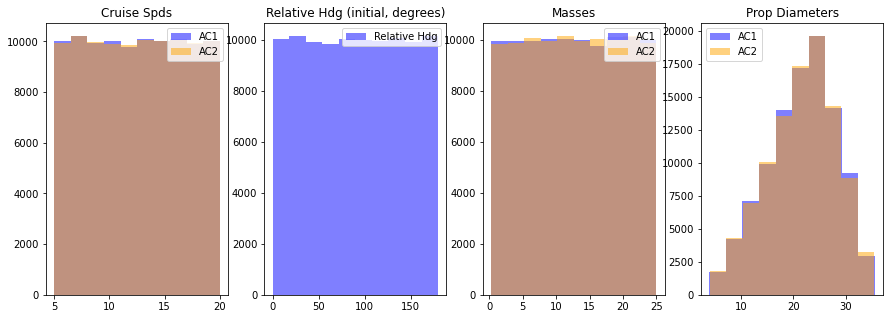

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(15,5))

axs[0].hist(param_df['AC1_Cruise_Speed'], label='AC1', color='b', alpha=0.5)
axs[0].hist(param_df['AC2_Cruise_Speed'], label='AC2', color='orange', alpha=0.5)
axs[0].set_title('Cruise Spds')
axs[0].legend()

axs[1].hist(param_df['Relative Hdg (initial, degrees)'], color='b', alpha=0.5, label = 'Relative Hdg')
axs[1].set_title('Relative Hdg (initial, degrees)')
axs[1].legend()

axs[2].hist(param_df['AC1_Mass'], color='b', alpha=0.5, label = 'AC1')
axs[2].hist(param_df['AC2_Mass'], color='orange', alpha=0.5, label = 'AC2')
axs[2].set_title('Masses')
axs[2].legend()

axs[3].hist(param_df['AC1_Prop_Diameter'], color='b', alpha=0.5, label = 'AC1')
axs[3].hist(param_df['AC2_Prop_Diameter'], color='orange', alpha=0.5, label = 'AC2')
axs[3].set_title('Prop Diameters')
axs[3].legend()

plt.show()

In [7]:
def special_dot(a, b):
    """"""
    num_elem = len(a[0])
    temp = np.zeros(num_elem)
    for row_num in range(len(a)):
        temp += a[row_num] * b[row_num]
    return temp

def vectorize_dcap_calc(AC1_pos, AC1_vel, AC2_pos, AC2_vel):
    """ACx_pos: n row by m column numpy array containing position coordinates. 
    n reflects the dimension of the phase space, while m is the number of data 
    points for which DCAP needs to be calculated."""
    
    xc = AC1_pos - AC2_pos
    vc = AC1_vel - AC2_vel
    vcsq = special_dot(vc, vc)
    t_DCAP = - special_dot(xc, vc)/vcsq
    # print(t_DCAP)
    t_DCAP_temp = t_DCAP.copy()
    
    t_DCAP_temp[t_DCAP_temp == np.inf] = 0
    t_DCAP_temp[t_DCAP_temp == -np.inf] = 0
    t_DCAP_temp = np.nan_to_num(t_DCAP_temp)
    
    t_DCAP[t_DCAP == np.inf] = np.NaN
    t_DCAP[t_DCAP == -np.inf] = np.NaN
    
    a = AC1_pos + t_DCAP_temp*AC1_vel
    b = AC2_pos + t_DCAP_temp*AC2_vel
    cc = a - b
    dist = np.sqrt(special_dot(cc, cc))
    
    return (t_DCAP, dist)

param_df['AC1_Est_Cruise_Speed_x'] = param_df['AC1_Cruise_Speed'] * np.cos(param_df['AC1_HDG'])
param_df['AC1_Est_Cruise_Speed_y'] = param_df['AC1_Cruise_Speed'] * np.sin(param_df['AC1_HDG'])
param_df['AC1_Est_Cruise_Speed_z'] = np.zeros(len(param_df))

param_df['AC2_Est_Cruise_Speed_x'] = param_df['AC2_Cruise_Speed'] * np.cos(param_df['AC2_HDG'])
param_df['AC2_Est_Cruise_Speed_y'] = param_df['AC2_Cruise_Speed'] * np.sin(param_df['AC2_HDG'])
param_df['AC2_Est_Cruise_Speed_z'] = np.zeros(len(param_df))


AC1_pos = np.array([param_df['AC1_Ini_Pos_x'], param_df['AC1_Ini_Pos_y'], param_df['AC1_Ini_Pos_z']])
AC2_pos = np.array([param_df['AC2_Ini_Pos_x'], param_df['AC2_Ini_Pos_y'], param_df['AC2_Ini_Pos_z']])
AC1_vel = np.array([param_df['AC1_Est_Cruise_Speed_x'], 
                    param_df['AC1_Est_Cruise_Speed_y'], 
                    param_df['AC1_Est_Cruise_Speed_z']])
AC2_vel = np.array([param_df['AC2_Est_Cruise_Speed_x'], 
                    param_df['AC2_Est_Cruise_Speed_y'], 
                    param_df['AC2_Est_Cruise_Speed_z']])

param_df['Predicted t_DCAP'], param_df['Predicted DCAP'] = vectorize_dcap_calc(AC1_pos, AC1_vel, AC2_pos, AC2_vel)

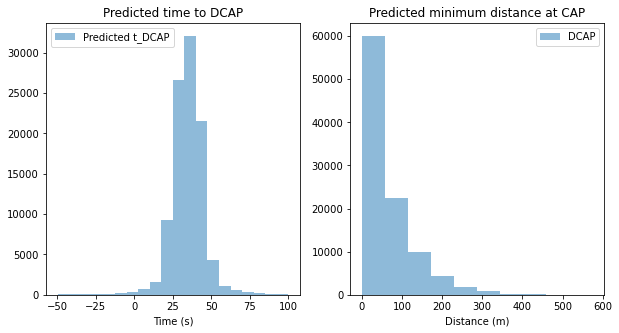

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# Filter t_DCAP plot for only values within +/- simulation timeframe
DCAP_df = param_df.loc[(param_df['Predicted t_DCAP'] <= 100) & 
                      (-50 <= param_df['Predicted t_DCAP'])]

ax[0].hist(DCAP_df['Predicted t_DCAP'], bins=20, alpha = 0.5, label = 'Predicted t_DCAP')
ax[0].set_title('Predicted time to DCAP')
ax[0].set_xlabel('Time (s)')
ax[0].legend()

ax[1].hist(param_df['Predicted DCAP'], alpha = 0.5, label = 'DCAP')
ax[1].set_title('Predicted minimum distance at CAP')
ax[1].set_xlabel('Distance (m)')
ax[1].legend()


plt.show()

In [9]:
# Save Initial Params
Init_Param_Path = join_str(os.getcwd(), 'MonteCarlo', 'TwoAircraftEncounter', 'Init_Param_Sensitivity_Analysis.csv')
Init_Param_Path

param_df.to_csv(Init_Param_Path)

In [10]:
BoEE = len(param_df.loc[param_df['Predicted DCAP'] < 1]) / len(param_df.loc[param_df['Predicted DCAP'] < 15])
print('Back-of-envelope estimate of P(NMAC|WCV) is %.3f'%BoEE) 

Back-of-envelope estimate of P(NMAC|WCV) is 0.117
